In [1]:
from model import HPEnet, HPERnet, Hopenet
import torch
from tqdm import tqdm
from facenet_pytorch import MTCNN
from torchvision import transforms
from scipy.spatial.transform import Rotation as R
import numpy as np 
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib as mpl
from dataset import PandoraDataset, AIWatchDataset, AFLW2000Dataset
import os
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
import pandas as pd
from termcolor import colored
import warnings
from utils import convert_class_cube_to_euler_angles
warnings.simplefilter('ignore')

### Load model and test set

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 1

# Load model from checkpoint
model = HPEnet().to(device)
model.load_state_dict(torch.load('models/val_2.6617_train_1.2211.pt'))
model.to(device);
model.eval()

# Load data
torch.manual_seed(42)
generator = torch.Generator()
generator.manual_seed(42)

pandora_dataset = PandoraDataset(cached=True)
aflw2000_dataset = AFLW2000Dataset(cached=True)
aiwatch_dataset = AIWatchDataset(cached=True)
dataset = torch.utils.data.ConcatDataset([pandora_dataset, aflw2000_dataset, aiwatch_dataset])
num_samples = len(dataset)

# Divide the dataset into train, validation and test sets
num_train_samples = int(0.9 * num_samples)
num_val_samples = int(0.05 * num_samples)
num_test_samples = num_samples - num_train_samples - num_val_samples

_, _, test_dataset = torch.utils.data.random_split(dataset, [num_train_samples, num_val_samples, num_test_samples], generator)

# Only take a subset of the test samples
#test_dataset = torch.utils.data.Subset(test_dataset, range(0, 100))

# reduce the number of samples for testing
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=True, generator=generator)

Loading the model...
PandoraDataset
Loading cached dataset...


100%|██████████| 138591/138591 [00:00<00:00, 4061916.77it/s]


AFLW2000Dataset
Loading cached dataset...


100%|██████████| 1930/1930 [00:00<00:00, 3851097.39it/s]


AIWatchDataset
Loading cached dataset...


100%|██████████| 107/107 [00:00<00:00, 1809639.23it/s]


### Run tests

In [3]:
# Run inference
predictions = []
targets = []

# Define a tqdm progress bar
with torch.inference_mode():
    progress_bar = tqdm(test_dataloader, desc='Inference', leave=True)
    for batch_idx, (face, rotation_matrix, class_label) in enumerate(progress_bar):
        face, rotation_matrix, class_label = face.to(device), rotation_matrix.to(device), class_label.to(device)
        _, _, _, predicted_class_label = model(face)
        
        predictions.append(convert_class_cube_to_euler_angles(predicted_class_label))
        targets.append(convert_class_cube_to_euler_angles(class_label))

# Classification report
predictions = torch.cat(predictions, dim=0)
targets = torch.cat(targets, dim=0)

report = classification_report(targets[:,0].cpu().numpy(), predictions[:,0].cpu().numpy(), output_dict=True)
roll_report_df = pd.DataFrame(report).transpose()
print(colored("Roll report", "green"))
print(roll_report_df)

report = classification_report(targets[:,1].cpu().numpy(), predictions[:,1].cpu().numpy(), output_dict=True)
yaw_report_df = pd.DataFrame(report).transpose()
print(colored("Yaw report", "green"))
print(yaw_report_df)

report = classification_report(targets[:,2].cpu().numpy(), predictions[:,2].cpu().numpy(), output_dict=True)
pitch_report_df = pd.DataFrame(report).transpose()
print(colored("Pitch report", "green"))
print(pitch_report_df)

# Confusion matrices
plt.clf()
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].set_title('Roll')
axes[1].set_title('Yaw')
axes[2].set_title('Pitch')

# Calculate and display confusion matrices
disp_roll = ConfusionMatrixDisplay.from_predictions(targets[:,0].cpu().numpy(), predictions[:,0].cpu().numpy(), cmap=mpl.colormaps["inferno"], ax=axes[0], include_values=False, xticks_rotation="vertical")
disp_yaw = ConfusionMatrixDisplay.from_predictions(targets[:,1].cpu().numpy(), predictions[:,1].cpu().numpy(), cmap=mpl.colormaps["inferno"], ax=axes[1], include_values=False, xticks_rotation="vertical")
disp_pitch = ConfusionMatrixDisplay.from_predictions(targets[:,2].cpu().numpy(), predictions[:,2].cpu().numpy(), cmap=mpl.colormaps["inferno"], ax=axes[2], include_values=False, xticks_rotation="vertical")

plt.show()


Inference:   0%|          | 0/7032 [00:00<?, ?it/s]

Inference:   0%|          | 0/7032 [00:01<?, ?it/s]

tensor([[ -4.9041,  -5.4666,  -6.7422,  ..., -15.6694, -16.4735, -17.1214]],
       device='cuda:0')


TypeError: only integer tensors of a single element can be converted to an index

### Test on single image

1410


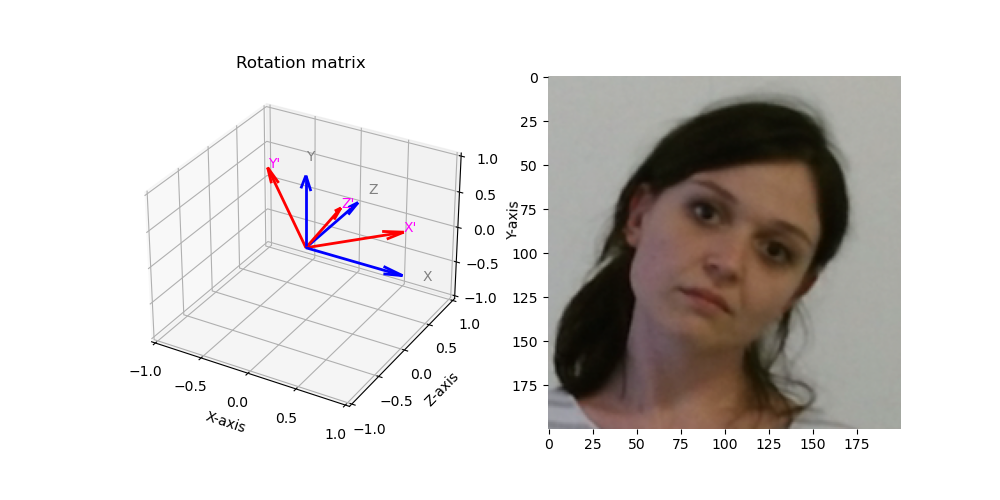

In [8]:
%matplotlib widget

def load_testset_face(fig):
    random_idx = np.random.randint(0, len(test_dataset))
    random_idx = 1410
    print(random_idx)
    face_tensor, _, _ = test_dataset[random_idx]
    mean = torch.load("/home/spoleto/hpe/serialized_dataset/pandora/mean.pt")
    std = torch.load("/home/spoleto/hpe/serialized_dataset/pandora/std.pt")

    face_image = face_tensor.permute(1, 2, 0)
    face_image = face_image * std + mean
    face_image = face_image.int()

    # Flip face
    face_tensor = face_tensor.flip(2)
    face_image = face_image.flip(1)



    ax1 = fig.add_subplot(122, frameon=False)
    ax1.imshow(face_image)

    return face_tensor

def load_path_face(fig, path = "dataset/test_image_9.png", flip=False):
    mean = torch.load('serialized_dataset/pandora/mean.pt')
    std = torch.load('serialized_dataset/pandora/std.pt')  

    # Load image with PIL
    image = Image.open(path).convert("RGB")
    if flip:
        image = image.transpose(Image.FLIP_LEFT_RIGHT)
    
    # Detect face
    mtcnn = MTCNN(select_largest=True, post_process=False, device='cuda:0')
    boxes, _ = mtcnn.detect(image)

    # Add margin while safe checking
    margin=50
    boxes[0][0] = max(0, boxes[0][0] - margin)
    boxes[0][1] = max(0, boxes[0][1] - margin)
    boxes[0][2] = min(image.width, boxes[0][2] + margin)
    boxes[0][3] = min(image.height, boxes[0][3] + margin)

    # Crop the face using boxes
    face = image.crop(boxes[0])

    transform = transforms.Compose([ 
        transforms.PILToTensor(),
        transforms.Resize((200, 200)),
    ])

    face_image = transform(face)
    face_image = face_image.permute(1, 2, 0)

    # Standardize the tensor
    #face_tensor = (face_image - mean) / std
    # Normalize face_image between 0 and 1
    face_tensor = face_image / 255
    ax1 = fig.add_subplot(122, frameon=False)
    ax1.imshow(face_tensor)
    face_tensor = face_tensor.permute(2, 0, 1)
    face_tensor = face_tensor.type(torch.float32)

    return face_tensor

def plot_rotated_axes(fig, rotation_matrix):
    x=1; y=1; z=1
    ax2 = fig.add_subplot(121, projection='3d')
    ax2.quiver(0, 0, 0, x, 0, 0, color='blue', arrow_length_ratio=0.2, linewidth=2)
    ax2.text(x*1.2, 0, 0, 'X', color='gray')

    ax2.quiver(0, 0, 0, 0, z, 0, color='blue', arrow_length_ratio=0.2, linewidth=2)
    ax2.text(0, z*1.2, 0, 'Z', color='gray')

    ax2.quiver(0, 0, 0, 0, 0, y, color='blue', arrow_length_ratio=0.2, linewidth=2)
    ax2.text(0, 0, y*1.2, 'Y', color='gray')

    # Apply rotation and draw the rotated axes
    new_x, new_y, new_z = np.dot(rotation_matrix, np.array([x, 0, 0]))
    ax2.quiver(0, 0, 0, new_x, new_y, new_z, color='red', arrow_length_ratio=0.2, linewidth=2)
    ax2.text(new_x, new_y, new_z, 'X\'', color='magenta')

    new_x, new_y, new_z = np.dot(rotation_matrix, np.array([0, z, 0]))
    ax2.quiver(0, 0, 0, new_x, new_y, new_z, color='red', arrow_length_ratio=0.2, linewidth=2)
    ax2.text(new_x, new_y, new_z, 'Z\'', color='magenta')

    new_x, new_y, new_z = np.dot(rotation_matrix, np.array([0, 0, y]))
    ax2.quiver(0, 0, 0, new_x, new_y, new_z, color='red', arrow_length_ratio=0.2, linewidth=2)
    ax2.text(new_x, new_y, new_z, 'Y\'', color='magenta')

    # Set axis labels
    ax2.set_xlabel('X-axis')
    ax2.set_ylabel('Z-axis')
    ax2.set_zlabel('Y-axis')

    # Set plot limits
    ax2.set_xlim([-1, 1])
    ax2.set_ylim([-1, 1])
    ax2.set_zlim([-1, 1])

    # Use fewer ticks
    ax2.set_xticks([-1, -0.5, 0, 0.5, 1])
    ax2.set_yticks([-1, -0.5, 0, 0.5, 1])
    ax2.set_zticks([-1, -0.5, 0, 0.5, 1])

    # Set plot title
    ax2.set_title('Rotation matrix')

def bins_to_rotation_matrix(roll_bin, yaw_bin, pitch_bin):
    roll_bin = torch.argmax(roll_bin, dim=1)
    yaw_bin = torch.argmax(yaw_bin, dim=1)
    pitch_bin = torch.argmax(pitch_bin, dim=1)

    roll_bins = list(range(-90, 95, 10))
    yaw_bins = list(range(-145, 150, 10))
    pitch_bins = list(range(-105, 110, 10))

    # Convert bins to intervals
    roll_bins = [(roll_bins[i], roll_bins[i+1]) for i in range(len(roll_bins)-1)]
    yaw_bins = [(yaw_bins[i], yaw_bins[i+1]) for i in range(len(yaw_bins)-1)]
    pitch_bins = [(pitch_bins[i], pitch_bins[i+1]) for i in range(len(pitch_bins)-1)]

    roll = (roll_bins[roll_bin][0] + roll_bins[roll_bin][1]) / 2
    yaw = (yaw_bins[yaw_bin][0] + yaw_bins[yaw_bin][1]) / 2
    pitch = (pitch_bins[pitch_bin][0] + pitch_bins[pitch_bin][1]) / 2

    rotation_matrix = R.from_euler('yzx', [roll, yaw, pitch], degrees=True).as_matrix()

    return rotation_matrix

# Create figure
fig = plt.figure(figsize=(10, 5))

# Load face
#face_tensor = load_path_face(fig, flip=True)
face_tensor = load_testset_face(fig)

# Inference
rotation_matrix = None
with torch.inference_mode():
    face_tensor = face_tensor.unsqueeze(0).to(device)
    r1, r2, r3, _ = model(face_tensor)

    # Create a numpy matrix out of r1, r2, r3 (these vectors are the columns of the rotation matrix)
    r1 = r1.squeeze().cpu().detach().numpy()
    r2 = r2.squeeze().cpu().detach().numpy()
    r3 = r3.squeeze().cpu().detach().numpy()
    rotation_matrix = np.array([r1, r2, r3])
    #rotation_matrix = bins_to_rotation_matrix(roll_bin, yaw_bin, pitch_bin)
plot_rotated_axes(fig, rotation_matrix)
plt.show()